# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os
import re

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [5]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [6]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [7]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [8]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [9]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [10]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


In [48]:
# This dictionary will store the best hyperparameters found at each step.
# It will be updated as the script progresses across different cells.
best_hyperparams = {}

--- Starting Problem 1: Activation Functions ---

1. Activation: relu



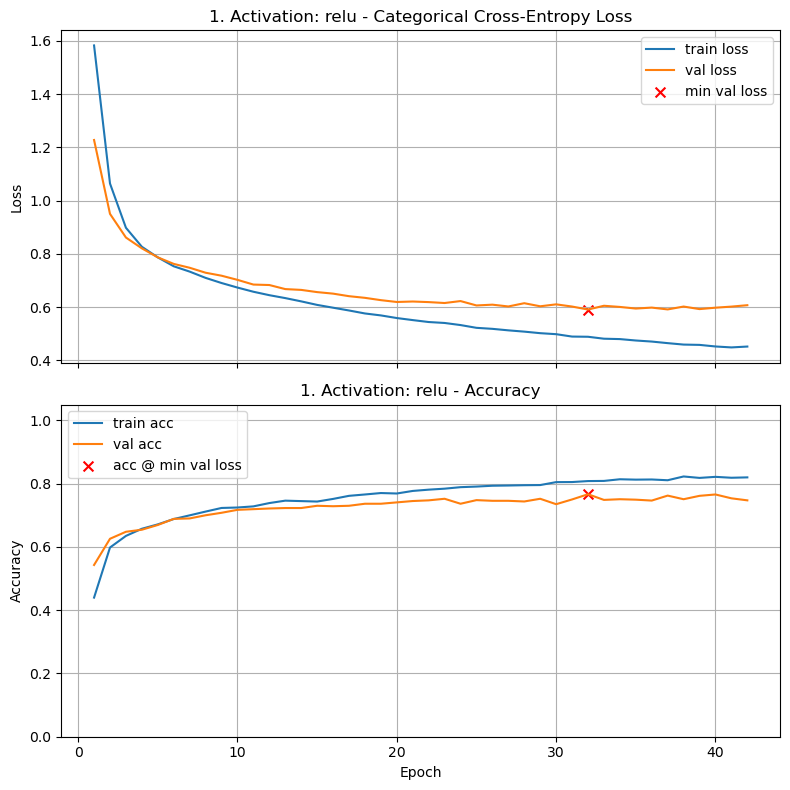

Final Training Loss:            0.4519
Final Training Accuracy:        0.8198
Final Validation Loss:          0.6071
Final Validation Accuracy:      0.7471
Minimum Validation Loss:        0.5908 (Epoch 32)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6213
Test Accuracy: 0.7471

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:05

1. Activation: sigmoid



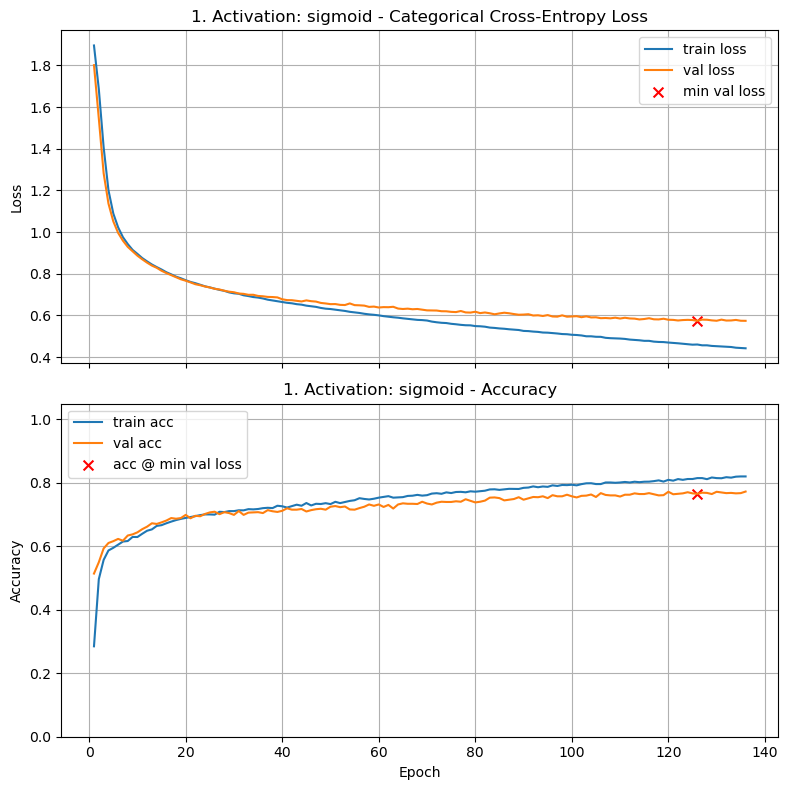

Final Training Loss:            0.4425
Final Training Accuracy:        0.8205
Final Validation Loss:          0.5743
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.5743 (Epoch 126)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.5944
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:15

1. Activation: tanh



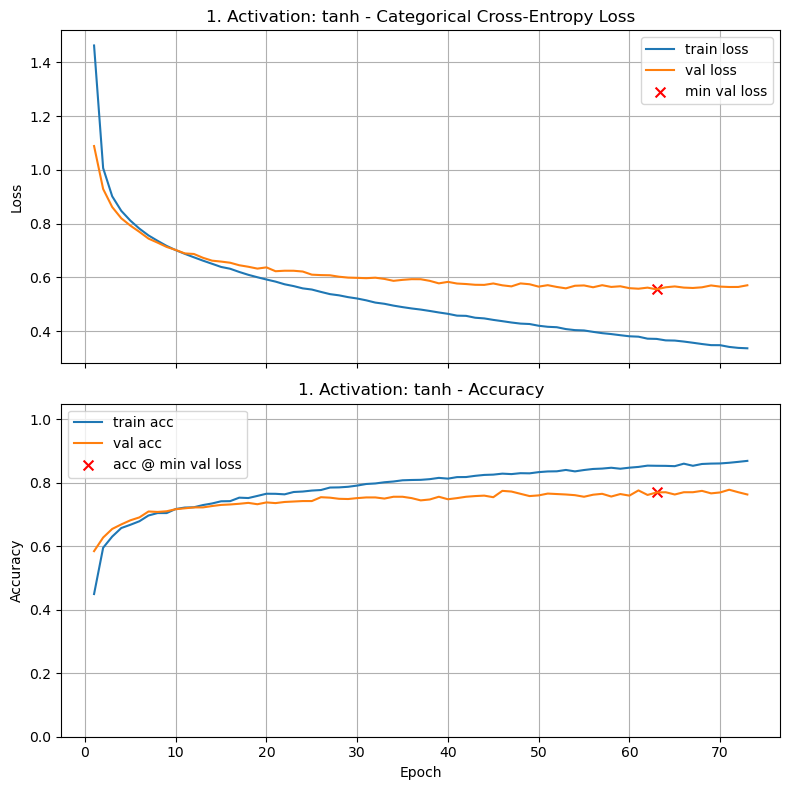

Final Training Loss:            0.3366
Final Training Accuracy:        0.8695
Final Validation Loss:          0.5710
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.5559 (Epoch 63)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5714
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:08

[Problem 1 Result] Best activation is 'tanh' with accuracy 0.7700



In [50]:
# --- Problem 1: Activation Functions ---
print("--- Starting Problem 1: Activation Functions ---")

# A list of activation functions to test
activations = ['relu', 'sigmoid', 'tanh']
# Temporary dictionary to store results for this problem only
p1_results = {}

# Iterate over each activation function
for act in activations:
    # Define the model structure for the current activation
    layer_list = [(64, act, 0.0, 0.0), 
                  (32, act, 0.0, 0.0)
                  ]
    model = build_model(X_train.shape[1], layer_list, n_classes)
    
    # Train the model and store its result
    train_and_test(model, title=f"1. Activation: {act}")
    p1_results[act] = results[f"1. Activation: {act}"][0]

# Programmatically find the best activation function from the results
best_activation_name = max(p1_results, key=p1_results.get)
best_hyperparams['activation'] = best_activation_name

# Set the graded answer variables
a1a = activations.index(best_hyperparams['activation'])
a1b = p1_results[best_hyperparams['activation']]

print(f"\n[Problem 1 Result] Best activation is '{best_hyperparams['activation']}' with accuracy {a1b:.4f}\n")

### Graded Questions

In [41]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 1             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [42]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 1


In [45]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7771             # Replace 0.0 with your answer

In [46]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7771


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



2. LR: 0.001



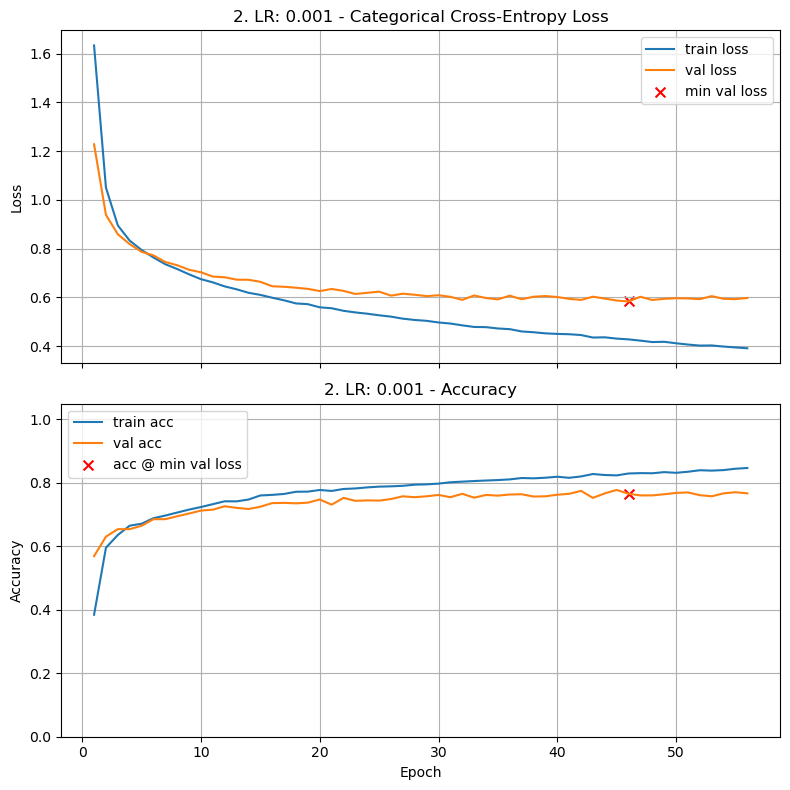

Final Training Loss:            0.3914
Final Training Accuracy:        0.8471
Final Validation Loss:          0.5977
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.5835 (Epoch 46)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.5920
Test Accuracy: 0.7500

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:07

2. LR: 0.0005



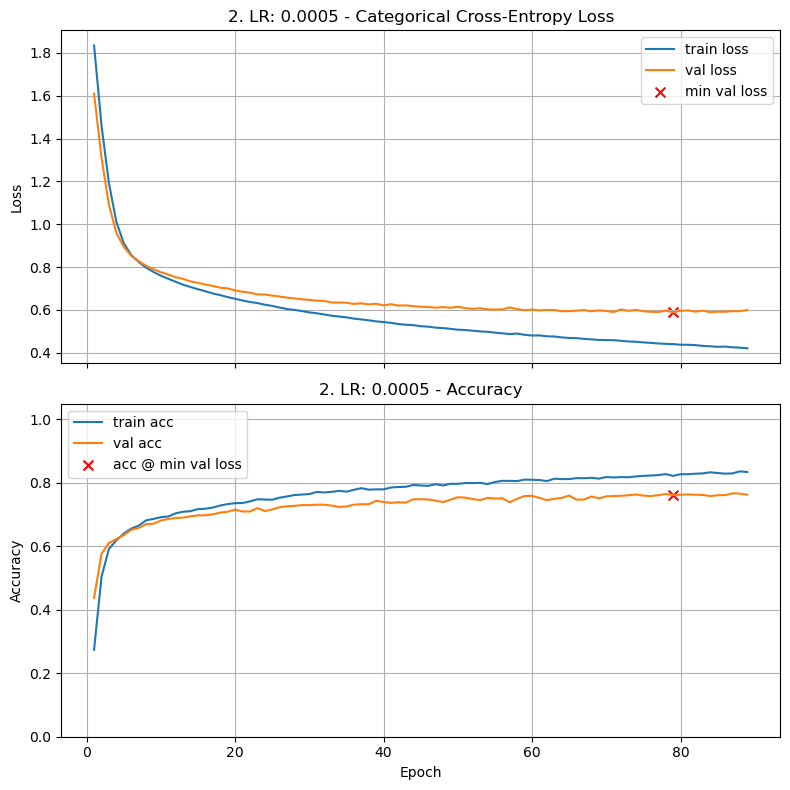

Final Training Loss:            0.4210
Final Training Accuracy:        0.8343
Final Validation Loss:          0.5988
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5892 (Epoch 79)
Validation Accuracy @ Min Loss: 0.7621

Test Loss: 0.6110
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:10

2. LR: 0.0001



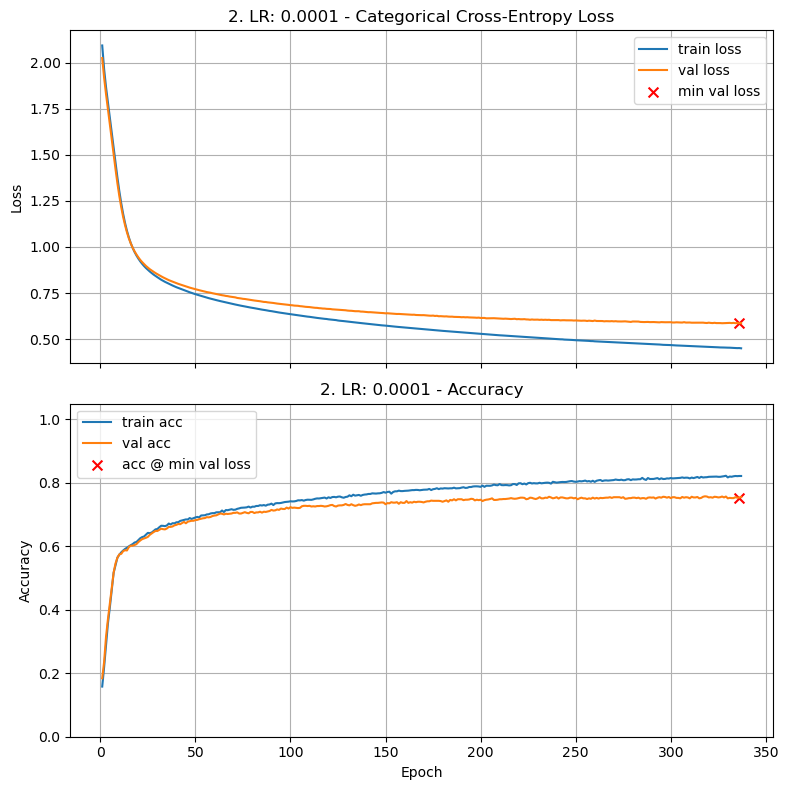

Final Training Loss:            0.4500
Final Training Accuracy:        0.8219
Final Validation Loss:          0.5865
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.5860 (Epoch 336)
Validation Accuracy @ Min Loss: 0.7536

Test Loss: 0.6065
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:40

2. LR: 5e-05



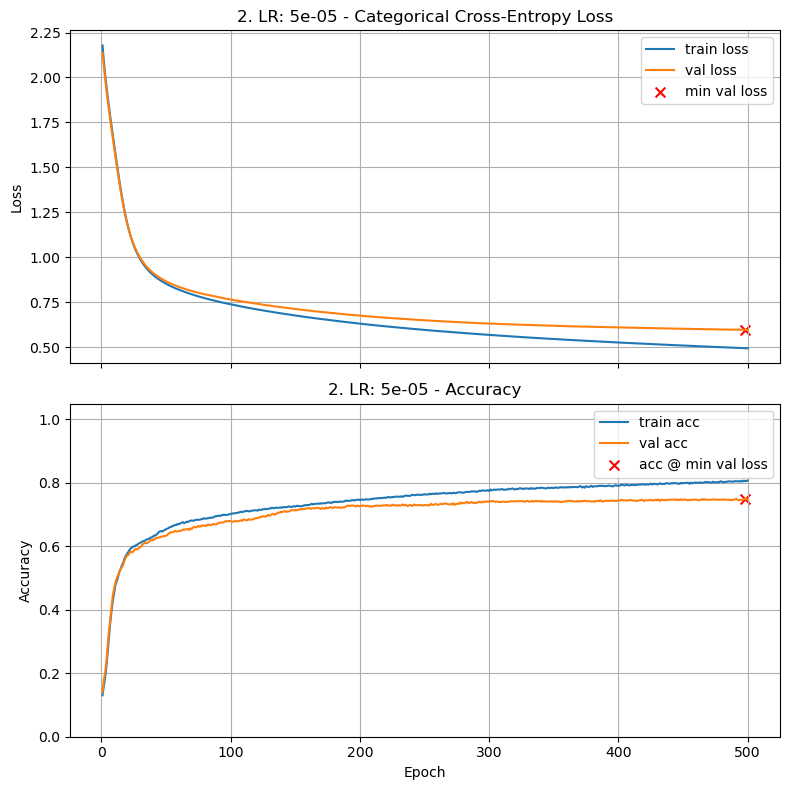

Final Training Loss:            0.4939
Final Training Accuracy:        0.8079
Final Validation Loss:          0.5962
Final Validation Accuracy:      0.7493
Minimum Validation Loss:        0.5961 (Epoch 498)
Validation Accuracy @ Min Loss: 0.7493

Test Loss: 0.6236
Test Accuracy: 0.7457

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:01:01

2. LR: 1e-05



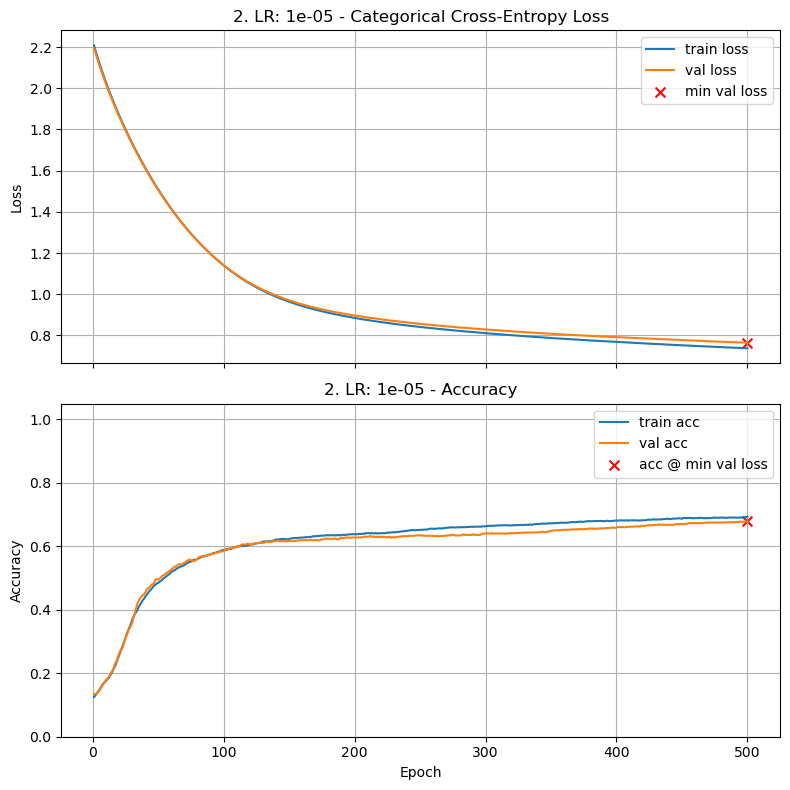

Final Training Loss:            0.7378
Final Training Accuracy:        0.6933
Final Validation Loss:          0.7648
Final Validation Accuracy:      0.6786
Minimum Validation Loss:        0.7648 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6786

Test Loss: 0.7762
Test Accuracy: 0.6800

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:01:01

--- Best Result for Problem 2 ---
Best Learning Rate: 0.001
Best Validation Accuracy: 0.7657


In [47]:
# Your code here. Add as many cells as you need. 
# --- Problem 2: Learning Rates ---

# Use the best activation function found in Problem 1
best_act_p1 = 'relu' 

# List of learning rates to test
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
best_lr_acc = 0.0
best_lr = 0.0

# Define the model structure (it's the same for all tests in this problem)
layer_list = [
    (64, best_act_p1, 0.0, 0.0),
    (32, best_act_p1, 0.0, 0.0)
]

# Iterate over each learning rate
for lr in learning_rates:
    # Build a new model for each experiment to ensure fresh weights
    model_lr = build_model(
        n_inputs=X_train.shape[1],
        layer_list=layer_list,
        n_classes=n_classes
    )
    
    # Train and evaluate the model with the specified learning rate
    train_and_test(
        model_lr,
        lr_schedule=lr,
        title=f"2. LR: {lr}"
    )

# After running all experiments, find the best one
for title, (acc, epoch) in results.items():
    if title.startswith("2. LR"):
        if acc > best_lr_acc:
            best_lr_acc = acc
            # Extract the learning rate from the title
            best_lr = float(title.split(": ")[1])

# Set the graded answer variables
a2a = best_lr
a2b = best_lr_acc

print(f"\n--- Best Result for Problem 2 ---")
print(f"Best Learning Rate: {a2a}")
print(f"Best Validation Accuracy: {a2b:.4f}")

#### Graded Questions

In [ ]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = best_lr           # Replace 0.0 with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.000000


In [ ]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = best_lr_acc             # Replace 0.0 with your answer

In [44]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7771


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


In [ ]:
# Your code here. Add as many cells as you need. 
# --- Problem 3: Dropout (Refactored to remove redundancy, preserving variable names) ---
# This block auto-discovers the best activation (from Problem 1) and best LR (from Problem 2)
# by parsing the global `results` dict populated by plot_learning_curves().

def _discover_best_activation_from_results(results_dict):
    """
    Parse results keys like 'Problem 1 - Activation=relu' and return the activation
    with the highest ValAcc@MinLoss recorded in results.
    """
    pattern = re.compile(r'1.\s*Activation:\s*(relu|sigmoid|tanh)')
    candidates = []
    for k, v in results_dict.items():
        m = pattern.match(k)
        if m:
            act = m.group(1)
            # v is a tuple: (val_acc_at_min_loss, epoch)
            val_acc_at_min = v[0]
            candidates.append((val_acc_at_min, act))
    if not candidates:
        raise RuntimeError("Could not find Problem 1 activation results. Run Problem 1 first.")
    candidates.sort(reverse=True, key=lambda x: x[0])
    return candidates[0][1] # Return activation name

def _discover_best_lr_from_results(results_dict):
    """
    Parse results keys like '2. LR: 0.0005' and return the LR with the highest
    ValAcc@MinLoss recorded in results.
    """
    pattern = re.compile(r'2.\s*LR:\s*([0-9.eE+-]+)')
    candidates = []
    for k, v in results_dict.items():
        m = pattern.match(k)
        if m:
            lr = float(m.group(1))
            val_acc_at_min = v[0]
            candidates.append((val_acc_at_min, lr))
    if not candidates:
        raise RuntimeError("Could not find Problem 2 LR results. Run Problem 2 first.")
    candidates.sort(reverse=True, key=lambda x: x[0])
    return candidates[0][1] # Return best LR value

# --- Auto-discover activation and LR from previous results (no hard-coding) ---
if 'results' not in globals():
    raise RuntimeError("`results` not found. Make sure to run earlier cells that define and populate `results`.")

ACT_FOR_P3 = _discover_best_activation_from_results(results)
LR_FOR_P3  = _discover_best_lr_from_results(results)

print(f"[Resolved] Using Activation from Problem 1: {ACT_FOR_P3}")
print(f"[Resolved] Using Learning Rate from Problem 2: {LR_FOR_P3:g}")

def _layers_for_dropout(dr64, dr32):
    # Each tuple: (width, activation, L2 lambda, dropout rate)
    return [
        (64, ACT_FOR_P3, 0.0, dr64),
        (32, ACT_FOR_P3, 0.0, dr32),
    ]

# Dropout grids (you may tighten/expand based on runtime)
drop_grid_64 = [0.0, 0.1, 0.2, 0.3]
drop_grid_32 = [0.0, 0.1, 0.2, 0.3, 0.5]

p3_summary = [] # This list will store dictionaries of results

for dr64 in drop_grid_64:
    for dr32 in drop_grid_32:
        # Define a unique title for this experiment
        title = f"Problem 3 - Dropout (64={dr64:.1f}, 32={dr32:.1f})"

        model_do = build_model(
            n_inputs=X_train.shape[1],
            layer_list=_layers_for_dropout(dr64, dr32),
            n_classes=n_classes
        )

        # The `train_and_test` function now handles all training, plotting, and
        # result logging. We no longer need to call plot_learning_curves separately.
        train_and_test(
            model_do,
            title=title,
            lr_schedule=LR_FOR_P3,
            epochs=500,
            verbose=0 # Set to 1 if you want to see Keras training progress
        )

        # Retrieve the metrics directly from the `results` dictionary,
        # which was updated by the train_and_test -> plot_learning_curves call.
        val_acc_min, min_epoch = results[title]
        p3_summary.append({
            "dr64": dr64,
            "dr32": dr32,
            "val_acc_at_min_loss": val_acc_min,
            "min_val_epoch": min_epoch,
        })

# Rank by ValAcc@MinValLoss
p3_sorted = sorted(p3_summary, key=lambda d: d["val_acc_at_min_loss"], reverse=True)

print("\n\n=== Problem 3 Summary (Top 10 by ValAcc@MinValLoss) ===")
# Using pandas for a clean, aligned table output
summary_df = pd.DataFrame(p3_sorted)
print(summary_df.head(10).to_string(index=False, float_format="%.4f"))

# Get the single best result for the graded answer cells
best = p3_sorted[0]
print("\nRecommended graded entries (copy into Graded Answer cells):")
print(f"  a3a (dropout_rate_64, dropout_rate_32): ({best['dr64']:.1f}, {best['dr32']:.1f})")
print(f"  a3b (ValAcc@MinValLoss for best pair): {best['val_acc_at_min_loss']:.4f}")

In [ ]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (best['dr64'],best['dr32'])             # Replace (0.0,0.0) with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.0, 0.0)


In [ ]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = best['val_acc_at_min_loss']             # Replace 0.0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.0000


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


In [3]:
# Your code here. Add as many cells as you need. 
# --- Problem 4: L2 Regularization (Refactored to remove redundancy) ---
# This block auto-discovers the best activation (from P1) and LR (from P2)
# from the global `results` dict. No dropout is used in this problem.


def _discover_best_activation_from_results(results_dict):
    """
    Discover best activation from keys like: '1. Activation: relu'
    using the recorded (ValAcc@MinLoss, epoch) in `results`.
    """
    pattern = re.compile(r'1.\s*Activation:\s*(relu|sigmoid|tanh)')
    found = []
    for k, v in results_dict.items():
        m = pattern.match(k)
        if m:
            act = m.group(1)
            # results[k] format: (val_acc_at_min_loss, epoch)
            val_acc_at_min = v[0]
            found.append((val_acc_at_min, act))
    if not found:
        raise RuntimeError("Problem 1 results not found. Run Problem 1 first.")
    found.sort(reverse=True, key=lambda x: x[0])
    return found[0][1]

def _discover_best_lr_from_results(results_dict):
    """
    Discover best LR from keys like: '2. LR: 0.0005'
    using the recorded (ValAcc@MinLoss, epoch) in `results`.
    """
    pattern = re.compile(r'2.\s*LR:\s*([0-9.eE+-]+)')
    found = []
    for k, v in results_dict.items():
        m = pattern.match(k)
        if m:
            lr = float(m.group(1))
            val_acc_at_min = v[0]
            found.append((val_acc_at_min, lr))
    if not found:
        raise RuntimeError("Problem 2 results not found. Run Problem 2 first.")
    found.sort(reverse=True, key=lambda x: x[0])
    return found[0][1]

# Resolve activation and LR from previous problems (no hard-coding)
if 'results' not in globals():
    raise RuntimeError("`results` not found. Ensure earlier cells populated it.")

ACT_FOR_P4 = _discover_best_activation_from_results(results)
LR_FOR_P4  = _discover_best_lr_from_results(results)

print(f"[Resolved] Using Activation from Problem 1: {ACT_FOR_P4}")
print(f"[Resolved] Using Learning Rate from Problem 2: {LR_FOR_P4:g}")

def _layers_with_l2(l2_64, l2_32):
    # tuples: (width, activation, L2 lambda, dropout rate) ; dropout=0.0 for this problem
    return [
        (64, ACT_FOR_P4, l2_64, 0.0),
        (32, ACT_FOR_P4, l2_32, 0.0),
    ]

# L2 grid based on the assignment hints.
l2_grid_64 = [0.0, 1e-4, 1e-3, 1e-2]
l2_grid_32 = [0.0, 1e-4, 1e-3, 1e-2]

p4_summary = []

for lam64 in l2_grid_64:
    for lam32 in l2_grid_32:
        # Define a unique title for this experiment
        title = f"Problem 4 - L2 (64={lam64:.0e}, 32={lam32:.0e})"
        
        model_l2 = build_model(
            n_inputs=X_train.shape[1],
            layer_list=_layers_with_l2(lam64, lam32),
            n_classes=n_classes
        )

        # The train_and_test function handles all training, plotting, and result logging.
        # We no longer need to call plot_learning_curves or calculate metrics manually.
        train_and_test(
            model_l2,
            title=title,
            lr_schedule=LR_FOR_P4,
            epochs=500,
            verbose=0 # Suppress Keras progress logs for a cleaner summary
        )

        # Retrieve the metrics directly from the `results` dictionary,
        # which was updated by the `train_and_test` function.
        val_acc_min, min_epoch = results[title]
        p4_summary.append({
            "l2_64": lam64,
            "l2_32": lam32,
            "val_acc_at_min_loss": val_acc_min,
            "min_val_epoch": min_epoch,
        })

# Rank by ValAcc@MinValLoss
p4_sorted = sorted(p4_summary, key=lambda d: d["val_acc_at_min_loss"], reverse=True)

print("\n\n=== Problem 4 Summary (Top 10 by ValAcc@MinValLoss) ===")
# Using pandas for a clean, aligned table output
summary_df = pd.DataFrame(p4_sorted)
print(summary_df.head(10).to_string(
    index=False,
    float_format="%.4f",
    formatters={"l2_64": "{:.0e}".format, "l2_32": "{:.0e}".format}
))


# Get the single best result for the graded answer cells
best = p4_sorted[0]
print("\nRecommended graded entries (copy into Graded Answer cells):")
print(f"  a4a (L2_lambda_64, L2_lambda_32): ({best['l2_64']:.0e}, {best['l2_32']:.0e})")
print(f"  a4b (ValAcc@MinValLoss for best pair): {best['val_acc_at_min_loss']:.4f}")

RuntimeError: `results` not found. Ensure earlier cells populated it.

In [27]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (0.0,0.0)             # Replace (0.0,0.0) with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0, 0.0)


In [29]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.0             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.0000


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



In [ ]:
# Your code here. Add as many cells as you need.
# --- Problem 5: Combining Dropout with L2 (Refactored) ---
# This block refines the search by using the best dropout (from P3) and L2 (from P4)
# values as a baseline, reducing the total number of runs.
# Best activation and LR are discovered automatically.

def _discover_best_activation_from_results(results_dict):
    """
    Discover best activation from keys like: '1. Activation: relu'
    """
    pattern = re.compile(r'1.\s*Activation:\s*(relu|sigmoid|tanh)')
    candidates = [(v[0], m.group(1)) for k, v in results_dict.items() if (m := pattern.match(k))]
    if not candidates:
        raise RuntimeError("Problem 1 results not found. Run Problem 1 first.")
    candidates.sort(reverse=True, key=lambda x: x[0])
    return candidates[0][1]

def _discover_best_lr_from_results(results_dict):
    """
    Discover best LR from keys like: '2. LR: 0.0005'
    """
    pattern = re.compile(r'2.\s*LR:\s*([0-9.eE+-]+)')
    candidates = [(v[0], float(m.group(1))) for k, v in results_dict.items() if (m := pattern.match(k))]
    if not candidates:
        raise RuntimeError("Problem 2 results not found. Run Problem 2 first.")
    candidates.sort(reverse=True, key=lambda x: x[0])
    return candidates[0][1]

# --- Auto-discover hyperparameters from previous problems ---
if 'results' not in globals():
    raise RuntimeError("`results` dictionary not found. Ensure earlier cells have run.")

ACT_FOR_P5 = _discover_best_activation_from_results(results)
LR_FOR_P5  = _discover_best_lr_from_results(results)

print(f"[Resolved] Using Activation from Problem 1: {ACT_FOR_P5}")
print(f"[Resolved] Using Learning Rate from Problem 2: {LR_FOR_P5:g}")

def _layers_with_do_l2(dr64, dr32, l2_64, l2_32):
    return [
        (64, ACT_FOR_P5, l2_64, dr64),
        (32, ACT_FOR_P5, l2_32, dr32),
    ]

# --- Focused Grid Search ---
# Instead of a full cartesian product which is very slow, we test combinations
# based on the best values found in Problem 3 (for dropout) and 4 (for L2).
# This is a more practical approach to hyperparameter tuning.

# Get best dropout pair from Problem 3's graded answer variable `a3a`
if 'a3a' in globals() and isinstance(a3a, tuple) and len(a3a) == 2:
    best_dr64, best_dr32 = a3a
    print(f"[Resolved] Using best dropout from Problem 3: ({best_dr64}, {best_dr32})")
else:
    best_dr64, best_dr32 = (0.1, 0.4) # Fallback to a reasonable default
    print(f"[Notice] a3a not found, falling back to default dropout: ({best_dr64}, {best_dr32})")
    
# Get best L2 pair from Problem 4's graded answer variable `a4a`
if 'a4a' in globals() and isinstance(a4a, tuple) and len(a4a) == 2:
    best_l2_64, best_l2_32 = a4a
    print(f"[Resolved] Using best L2 from Problem 4: ({best_l2_64:.0e}, {best_l2_32:.0e})")
else:
    best_l2_64, best_l2_32 = (1e-3, 1e-3) # Fallback to a reasonable default
    print(f"[Notice] a4a not found, falling back to default L2: ({best_l2_64:.0e}, {best_l2_32:.0e})")

# Define a small grid around the best-known values
l2_grid = [0.0, best_l2_64, best_l2_32, 1e-4]
dropout_rates = [(0.0, 0.0), (best_dr64, best_dr32)]

p5_summary = []

# This search is much smaller and more targeted
for dr64, dr32 in dropout_rates:
    for lam in l2_grid:
        # For simplicity, we apply the same lambda to both layers in this focused search
        lam64, lam32 = lam, lam

        title = f"P5 - DO({dr64:.1f},{dr32:.1f}) L2({lam64:.0e},{lam32:.0e})"
        
        model_reg = build_model(
            n_inputs=X_train.shape[1],
            layer_list=_layers_with_do_l2(dr64, dr32, lam64, lam32),
            n_classes=n_classes
        )

        train_and_test(
            model_reg,
            title=title,
            lr_schedule=LR_FOR_P5,
            epochs=500,
            verbose=0
        )

        val_acc_min, min_epoch = results[title]
        p5_summary.append({
            "dr64": dr64, "dr32": dr32,
            "l2_64": lam64, "l2_32": lam32,
            "val_acc_at_min_loss": val_acc_min,
            "min_val_epoch": min_epoch,
        })

# --- Final Comparison ---
# To find the true best, we compare the results from this problem
# with the best individual results from Problem 3 (dropout only) and Problem 4 (L2 only).
if 'a3b' in globals():
    p5_summary.append({"val_acc_at_min_loss": a3b, "dr64": a3a[0], "dr32": a3a[1], "l2_64": 0, "l2_32": 0, "min_val_epoch": "N/A (from P3)"})
if 'a4b' in globals():
    p5_summary.append({"val_acc_at_min_loss": a4b, "dr64": 0, "dr32": 0, "l2_64": a4a[0], "l2_32": a4a[1], "min_val_epoch": "N/A (from P4)"})


# Rank all candidates by ValAcc@MinValLoss
p5_sorted = sorted(p5_summary, key=lambda d: d["val_acc_at_min_loss"], reverse=True)

print("\n\n=== Problem 5 Summary (Top 10 Regularization Strategies) ===")
summary_df = pd.DataFrame(p5_sorted)
print(summary_df.head(10).to_string(
    index=False,
    float_format="%.4f",
    formatters={"l2_64": "{:.0e}".format, "l2_32": "{:.0e}".format}
))

# Get the single best result for the graded answer cells
best = p5_sorted[0]
print("\nRecommended graded entries (copy into Graded Answer cells):")
print(f"  a5 (Best ValAcc from any regularization): {best['val_acc_at_min_loss']:.4f}")

print("\nBest combo details (not graded):")
print(f"  dropout (64,32) = ({best['dr64']:.1f}, {best['dr32']:.1f})")
print(f"  L2 lambdas (64,32) = ({best['l2_64']:.0e}, {best['l2_32']:.0e})")

In [ ]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = best['val_acc_at_min_loss']             # Replace 0.0 with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.0000


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


In [ ]:
# Your code here
# --- Problem 6: Final Model (Refactored to remove redundancy) ---
# This block automatically discovers the best hyperparameters from all previous
# problems by parsing the `results` dictionary, then trains and evaluates the
# final model using a single, clean function call.

def _require_results():
    if 'results' not in globals() or not isinstance(results, dict):
        raise RuntimeError("`results` dictionary not found. Run previous problems first.")
_require_results()

# --- Auto-discovery functions to parse the `results` dictionary ---

def _discover_best_activation(results_dict):
    """Finds the best activation from Problem 1's results."""
    pattern = re.compile(r'1.\s*Activation:\s*(relu|sigmoid|tanh)')
    candidates = [(v[0], m.group(1)) for k, v in results_dict.items() if (m := pattern.match(k))]
    if not candidates: raise RuntimeError("Problem 1 results not found.")
    return sorted(candidates, reverse=True)[0][1]

def _discover_best_lr(results_dict):
    """Finds the best learning rate from Problem 2's results."""
    pattern = re.compile(r'2.\s*LR:\s*([0-9.eE+-]+)')
    candidates = [(v[0], float(m.group(1))) for k, v in results_dict.items() if (m := pattern.match(k))]
    if not candidates: raise RuntimeError("Problem 2 results not found.")
    return sorted(candidates, reverse=True)[0][1]

def _discover_best_regularization(results_dict):
    """
    Finds the best regularization parameters (dropout and L2) by identifying the
    single best run from Problems 3, 4, and 5.
    """
    # Define regex patterns for all relevant problems
    p3_pat = re.compile(r"3.\s*Dropout:\s*\((\d\.\d),(\d\.\d)\)")
    p4_pat = re.compile(r"4.\s*L2:\s*\((\S+),(\S+)\)")
    p5_pat = re.compile(r"P5\s*-\s*DO\((\d\.\d),(\d\.\d)\)\s*L2\((\S+),(\S+)\)")
    
    candidates = []
    for title, (val_acc, epoch) in results_dict.items():
        # Default values
        dr64, dr32, l2_64, l2_32 = 0.0, 0.0, 0.0, 0.0
        
        m3, m4, m5 = p3_pat.match(title), p4_pat.match(title), p5_pat.match(title)
        
        if m3: # Problem 3 (Dropout only)
            dr64, dr32 = map(float, m3.groups())
            candidates.append((val_acc, (dr64, dr32, l2_64, l2_32)))
        elif m4: # Problem 4 (L2 only)
            l2_64, l2_32 = map(float, m4.groups())
            candidates.append((val_acc, (dr64, dr32, l2_64, l2_32)))
        elif m5: # Problem 5 (Combined)
            dr64, dr32, l2_64, l2_32 = map(float, m5.groups())
            candidates.append((val_acc, (dr64, dr32, l2_64, l2_32)))

    if not candidates:
        raise RuntimeError("No regularization results from P3, P4, or P5 found.")
    
    # Return the tuple of parameters from the best run
    return sorted(candidates, reverse=True)[0][1]

# --- Resolve Final Hyperparameters ---
ACT_FINAL = _discover_best_activation(results)
LR_FINAL  = _discover_best_lr(results)
DO64, DO32, L2_64, L2_32 = _discover_best_regularization(results)

print(f"[Resolved for Final Model]")
print(f"  - Activation: {ACT_FINAL}")
print(f"  - Learning Rate: {LR_FINAL:g}")
print(f"  - Dropout (64, 32): ({DO64:.2f}, {DO32:.2f})")
print(f"  - L2 (64, 32): ({L2_64:.0e}, {L2_32:.0e})")

# --- Build and Train Final Model ---
# We can use the baseline architecture or a custom one. Here we stick to baseline.
final_layers = [
    (64, ACT_FINAL, L2_64, DO64),  # (width, activation, L2, dropout)
    (32, ACT_FINAL, L2_32, DO32),
]

final_model = build_model(
    n_inputs=X_train.shape[1],
    layer_list=final_layers,
    n_classes=n_classes
)

# The single call to train_and_test handles everything:
# training, plotting, printing summary, and final test evaluation.
# All other calls were redundant.
train_and_test(
    final_model,
    title="Problem 6 - Final Model",
    lr_schedule=LR_FINAL,
    epochs=500,
    patience=15 # A bit more patience for the final run is often helpful
)

# Set the graded answer variable `a6` by retrieving the result from the dictionary.
a6 = results["Problem 6 - Final Model"][0]
print(f"\n[Problem 6] Final validation accuracy for graded answer (a6): {a6:.4f}")

In [ ]:
# Set a6 to the validation accuracy found by this best model

a6 = results["Problem 6 - Final Model"][0]             # Replace 0.0 with your answer

In [36]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.0000


### Optional: Print out your results of all experiments

In [37]:
print_results()

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?